In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [2]:
def simulate_epid(model='SIR', beta=0.3, gamma=0.1, sigma=0.2,
                      S0=0.99, E0=0.0, I0=0.01, R0=0.0,
                      T=160, N=1.0, num_points=1000):
    """
    Simulate SIR or SEIR epidemic model over time.

    Parameters:
        model (str): 'SIR' or 'SEIR'
        beta (float): transmission rate
        gamma (float): recovery rate
        sigma (float): incubation rate (only used in SEIR)
        S0 (float): initial susceptible fraction
        E0 (float): initial exposed fraction (only used in SEIR)
        I0 (float): initial infected fraction
        R0 (float): initial recovered fraction
        T (float): total time to simulate
        N (float): total population size
        num_points (int): number of time points for simulation

    Returns:
        t (ndarray): time points
        result (ndarray): array with columns [S, (E), I, R] over time
    """
    t = np.linspace(0, T, num_points)

    # Define SIR model
    def sir_deriv(y, t, N, beta, gamma):
        S, I, R = y
        dSdt = -beta * S * I / N
        dIdt = beta * S * I / N - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt

    # Define SEIR model
    def seir_deriv(y, t, N, beta, sigma, gamma):
        S, E, I, R = y
        dSdt = -beta * S * I / N
        dEdt = beta * S * I / N - sigma * E
        dIdt = sigma * E - gamma * I
        dRdt = gamma * I
        return dSdt, dEdt, dIdt, dRdt

    if model == 'SIR':
        y0 = S0, I0, R0
        ret = odeint(sir_deriv, y0, t, args=(N, beta, gamma))
    elif model == 'SEIR':
        y0 = S0, E0, I0, R0
        ret = odeint(seir_deriv, y0, t, args=(N, beta, sigma, gamma))
    else:
        raise ValueError("Model must be 'SIR' or 'SEIR'")

    return t, ret


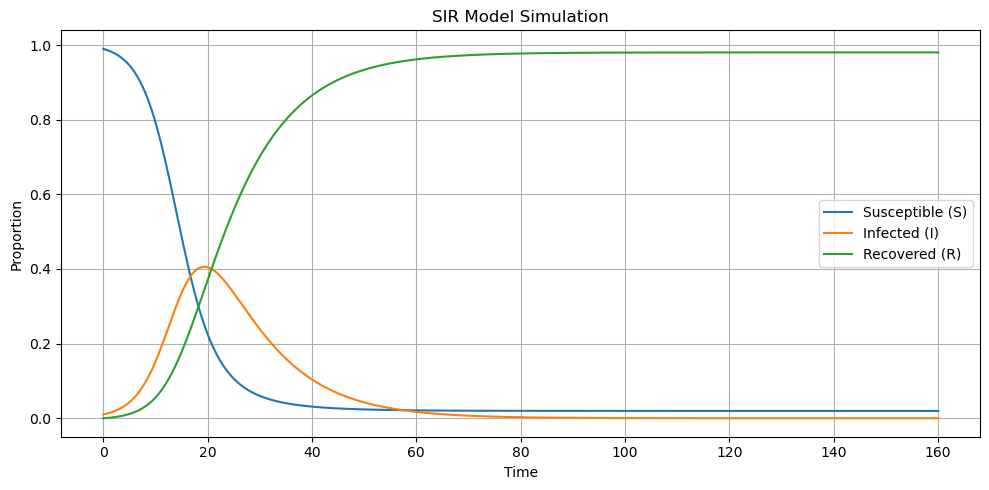

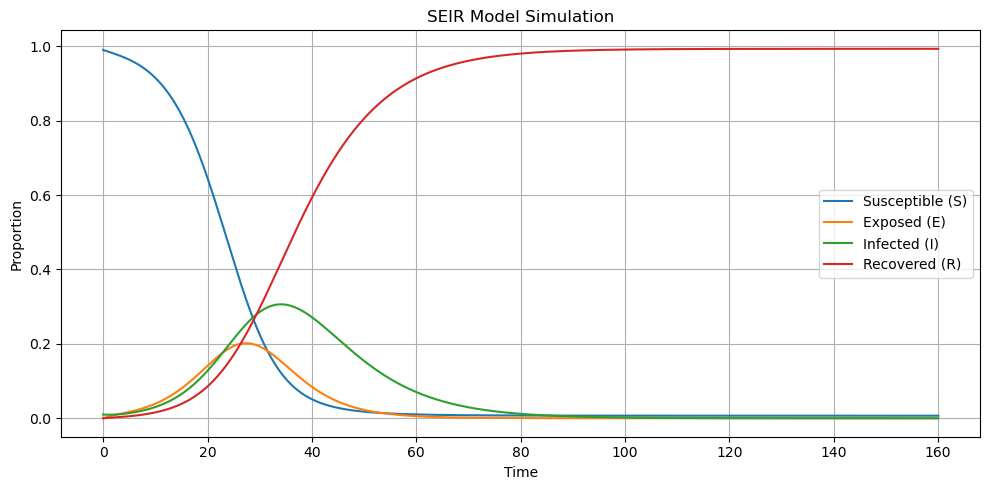

In [3]:
t_sir, result_sir = simulate_epid(
    model='SIR',
    beta=0.4,      # transmission rate
    gamma=0.1,     # recovery rate
    S0=0.99,       # initial susceptible
    I0=0.01,       # initial infected
    R0=0.0,        # initial recovered
    T=160          # total time
)

# Unpack SIR results
S_sir, I_sir, R_sir = result_sir.T

# Plot SIR
plt.figure(figsize=(10, 5))
plt.plot(t_sir, S_sir, label='Susceptible (S)')
plt.plot(t_sir, I_sir, label='Infected (I)')
plt.plot(t_sir, R_sir, label='Recovered (R)')
plt.title("SIR Model Simulation")
plt.xlabel("Time")
plt.ylabel("Proportion")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Example 2: Simulate SEIR model
t_seir, result_seir = simulate_epid(
    model='SEIR',
    beta=0.5,      # transmission rate
    sigma=0.2,     # incubation rate
    gamma=0.1,     # recovery rate
    S0=0.99,       # initial susceptible
    E0=0.0,        # initial exposed
    I0=0.01,       # initial infected
    R0=0.0,        # initial recovered
    T=160          # total time
)

# Unpack SEIR results
S_seir, E_seir, I_seir, R_seir = result_seir.T

# Plot SEIR
plt.figure(figsize=(10, 5))
plt.plot(t_seir, S_seir, label='Susceptible (S)')
plt.plot(t_seir, E_seir, label='Exposed (E)')
plt.plot(t_seir, I_seir, label='Infected (I)')
plt.plot(t_seir, R_seir, label='Recovered (R)')
plt.title("SEIR Model Simulation")
plt.xlabel("Time")
plt.ylabel("Proportion")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Continuous-Time Markov Chain Simulation of Epidemic Models

We use the **Gillespie Algorithm** to simulate SIR and SEIR models as **stochastic processes**. CTMC captures the randomness of individual-level transmission and recovery events.

## Event Mechanisms

### SIR Model
- **Infection:** $ S + I \xrightarrow{\beta \frac{SI}{N}} I + I $
- **Recovery:** $ I \xrightarrow{\gamma} R $

### SEIR Model
- **Infection:** $ S + I \xrightarrow{\beta \frac{SI}{N}} E + I $
- **Incubation:** $ E \xrightarrow{\sigma} I $
- **Recovery:** $ I \xrightarrow{\gamma} R $

## Algorithm Steps

1. **Initialize** the state vector $ (S, [E,] I, R) $ and time $ t = 0 $.
2. **Compute rates** of all possible transitions.
3. **Draw waiting time** $ \Delta t \sim \text{Exponential}(\text{total rate}) $.
4. **Choose event** with probability proportional to rate.
5. **Update state** and advance time.
6. **Repeat** until max time or no infected individuals remain.


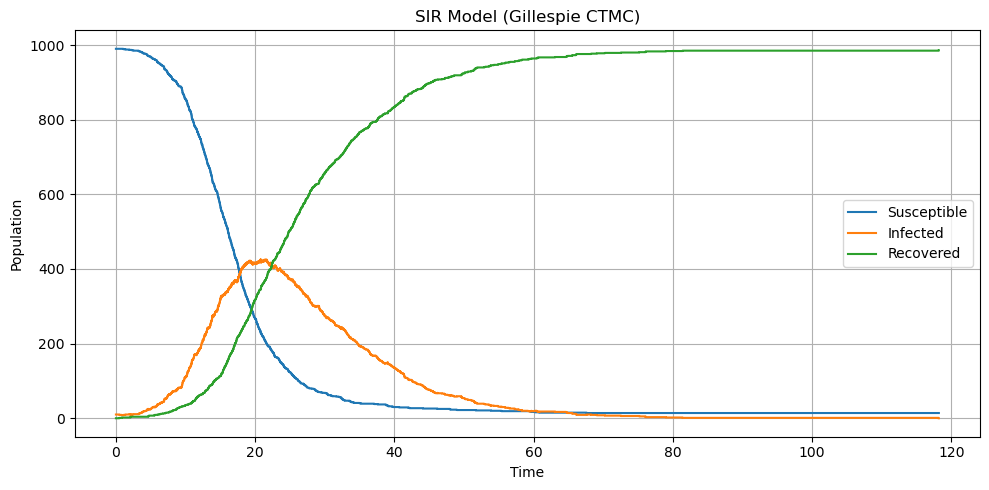

In [4]:
def simulate_epid_ctmc(model='SIR', beta=0.3, gamma=0.1, sigma=0.2,
                       S0=990, E0=0, I0=10, R0=0, T=160):
    t = 0.0
    times = [t]
    model_list = ['SIR', 'SEIR']

    if model == 'SIR':
        state = [S0, I0, R0]
        active_idx = 1  # check I
    elif model == 'SEIR':
        state = [S0, E0, I0, R0]
        active_idx = 2  # check I
    else:
        raise ValueError(f"Unknown model '{model}', must be one of {model_list}")

    states = [state.copy()]

    while t < T and state[active_idx] > 0:
        if model == 'SIR':
            S, I, R = state
            N = S + I + R
            rates = [beta * S * I / N,    # infection
                     gamma * I]          # recovery
            transitions = [[-1, +1,  0],
                           [ 0, -1, +1]]
        elif model == 'SEIR':  # SEIR
            S, E, I, R = state
            N = S + E + I + R
            rates = [beta  * S * I / N,   # infection
                     sigma * E,           # E -> I
                     gamma * I]           # recovery
            transitions = [[-1, +1,  0,  0],
                           [ 0, -1, +1,  0],
                           [ 0,  0, -1, +1]]

        total_rate = sum(rates)
        if total_rate == 0:
            break

        # time to next event
        dt = np.random.exponential(1 / total_rate)
        t += dt

        # choose which event
        event = np.random.choice(len(rates), p=np.array(rates)/total_rate)
        # apply transition
        for j, delta in enumerate(transitions[event]):
            state[j] += delta

        times.append(t)
        states.append(state.copy())

    return np.array(times), np.array(states)

# Run SIR CTMC
times, states = simulate_epid_ctmc(model='SIR', beta=0.4, gamma=0.1, S0=990, I0=10, R0=0, T=160)
S, I, R = states.T

plt.figure(figsize=(10, 5))
plt.step(times, S, where='post', label='Susceptible')
plt.step(times, I, where='post', label='Infected')
plt.step(times, R, where='post', label='Recovered')
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("SIR Model (Gillespie CTMC)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



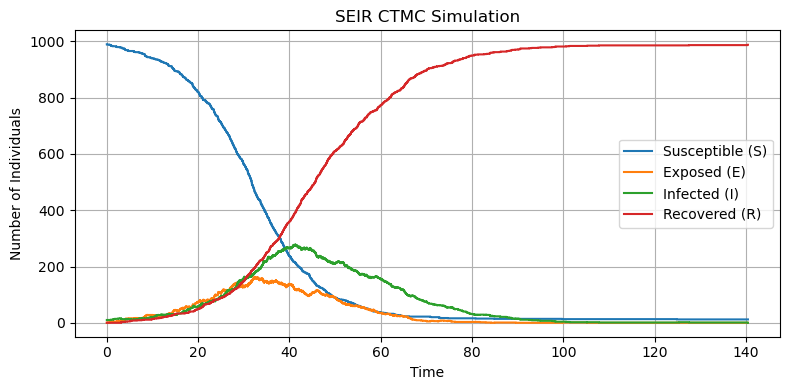

In [15]:
t_seir, traj_seir = simulate_epid_ctmc(
    model='SEIR', beta=0.4, sigma=0.2, gamma=0.1,
    S0=990, E0=0, I0=10, R0=0, T=160
)

S_seir, E_seir, I_seir, R_seir = traj_seir.T

plt.figure(figsize=(8, 4))
plt.step(t_seir, S_seir, where='post', label='Susceptible (S)')
plt.step(t_seir, E_seir, where='post', label='Exposed (E)')
plt.step(t_seir, I_seir, where='post', label='Infected (I)')
plt.step(t_seir, R_seir, where='post', label='Recovered (R)')
plt.xlabel('Time')
plt.ylabel('Number of Individuals')
plt.title('SEIR CTMC Simulation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Metapopulation CTMC: SIR and SEIR Models

We consider a collection of $P$ patches (e.g.\ cities, regions), each hosting a local population.  Individuals in each patch can
1. **Change disease status** via “within‐patch” SIR or SEIR transitions
2. **Move** between patches

Below we describe the compartments, the allowed events, their rates (propensities), and the core Gillespie (“next‐reaction”) loop.


## 1. Compartments

For patch $i=1,\dots,P$:

- **SIR** model:
  $$
    S_i(t),\ I_i(t),\ R_i(t),\quad
    N_i = S_i+I_i+R_i
  $$
- **SEIR** model:
  $$
    S_i(t),\ E_i(t),\ I_i(t),\ R_i(t),\quad
    N_i = S_i+E_i+I_i+R_i
  $$


## 2. Within‐Patch Transitions

### SIR
1. **Infection**
   $$
     S_i + I_i \;\xrightarrow{\beta\,\frac{S_i\,I_i}{N_i}}\; 2\,I_i
   $$
   Susceptible in patch $i$ becomes infectious at rate
   $\lambda_i = \beta\,S_i\,I_i/N_i$.

2. **Recovery**
   $$
     I_i \;\xrightarrow{\gamma\,I_i}\; R_i
   $$

### SEIR
1. **Infection**
   $$
     S_i + I_i \;\xrightarrow{\beta\,\tfrac{S_i\,I_i}{N_i}}\; E_i + I_i
   $$
2. **Incubation**
   $$
     E_i \;\xrightarrow{\sigma\,E_i}\; I_i
   $$
3. **Recovery**
   $$
     I_i \;\xrightarrow{\gamma\,I_i}\; R_i
   $$


## 3. Between‐Patch Movement

Each individual (in status $c\in\{S,E,I,R\}$) in patch $i$ moves to patch $j$ at rate
$$
  m_{i\to j}\times (\text{number in status }c\text{ in patch }i)\,.
$$
Movement events:
$$
  c_i \;\xrightarrow{m_{i\to j}\,c_i}\; c_j\,.
$$

In [7]:

def simulate_metapop_ctmc(model='SIR',
                          beta=0.3,
                          gamma=0.1,
                          sigma=0.2,
                          movement=None,
                          init=None,
                          T=160.0):
    """
    Simulate a P-patch metapopulation SIR/SEIR model via Gillespie CTMC
    with time-varying movement rates.

    Parameters
    ----------
    model : str
        'SIR' or 'SEIR'.
    beta : float
        Transmission rate.
    gamma : float
        Recovery rate.
    sigma : float
        Incubation rate (only used if model=='SEIR').
    movement : array-like or list or callable
        - If array shape (P,P): constant movement matrix.
        - If list of length M of arrays (P,P): piecewise-constant in M time bins.
        - If callable: function m(t) returning (P,P) matrix at time t.
    init : array_like
        Initial populations. Shape = (P,3) for SIR as [S,I,R] per patch,
                       or (P,4) for SEIR as [S,E,I,R] per patch.
    T : float
        Simulation end time.

    Returns
    -------
    times : ndarray, shape (M,)
        The jump times (sorted) up to T.
    states : ndarray, shape (M, P, C)
        The population in each compartment at each recorded time.
        C = 3 for SIR, C = 4 for SEIR.
    """
    init = np.asarray(init, dtype=int)
    P = init.shape[0]
    if model == 'SIR':
        C = 3
        if init.shape != (P, 3):
            raise ValueError("init must be shape (P,3) for SIR")
    elif model == 'SEIR':
        C = 4
        if init.shape != (P, 4):
            raise ValueError("init must be shape (P,4) for SEIR")
    else:
        raise ValueError("Model must be 'SIR' or 'SEIR'")

    # Pre-process movement specification
    if movement is None:
        def m_func(t):
            return np.zeros((P, P))
    elif callable(movement):
        m_func = movement
    else:
        mv = list(movement) if isinstance(movement, (list, tuple)) else np.asarray(movement)
        if mv.ndim == 2:
            # constant matrix
            def m_func(t):
                return mv
        elif mv.ndim == 3 and mv.shape[0] > 1:
            # time‐binned list of matrices
            times_bins = np.linspace(0, T, mv.shape[0])
            def m_func(t):
                idx = np.searchsorted(times_bins, t, side='right') - 1
                idx = max(0, min(idx, mv.shape[0]-1))
                return mv[idx]
        else:
            raise ValueError("movement must be (P,P), list of (P,P), or function")

    state = init.copy()
    t = 0.0
    times = [t]
    states = [state.copy()]

    while t < T:
        prop = []
        trans = []

        # a) within‐patch
        for i in range(P):
            if model == 'SIR':
                S, I, R = state[i]
                N = S + I + R
                # infection
                prop.append(beta * S*I / N)
                d = np.zeros((P, C), int)
                d[i,0] -= 1; d[i,1] += 1
                trans.append(d)
                # recovery
                prop.append(gamma * I)
                d = np.zeros((P, C), int)
                d[i,1] -= 1; d[i,2] += 1
                trans.append(d)
            elif model == 'SEIR':  # SEIR
                S, E, I, R = state[i]
                N = S + E + I + R
                # infection
                prop.append(beta * S*I / N)
                d = np.zeros((P, C), int)
                d[i,0] -= 1; d[i,1] += 1
                trans.append(d)
                # incubation
                prop.append(sigma * E)
                d = np.zeros((P, C), int)
                d[i,1] -= 1; d[i,2] += 1
                trans.append(d)
                # recovery
                prop.append(gamma * I)
                d = np.zeros((P, C), int)
                d[i,2] -= 1; d[i,3] += 1
                trans.append(d)

        # b) between‐patch movement
        m_matrix = m_func(t)
        for i in range(P):
            for j in range(P):
                if i == j: continue
                rate = m_matrix[i,j]
                if rate <= 0: continue
                for c in range(C):
                    prop.append(rate * state[i,c])
                    d = np.zeros((P, C), int)
                    d[i,c] -= 1; d[j,c] += 1
                    trans.append(d)

        a0 = sum(prop)
        if a0 <= 0:
            break

        dt = np.random.exponential(1.0/a0)
        t += dt
        if t > T:
            break

        u = np.random.rand()
        cum = np.cumsum(prop)/a0
        k = np.searchsorted(cum, u)
        state += trans[k]

        times.append(t)
        states.append(state.copy())

    return np.array(times), np.array(states)

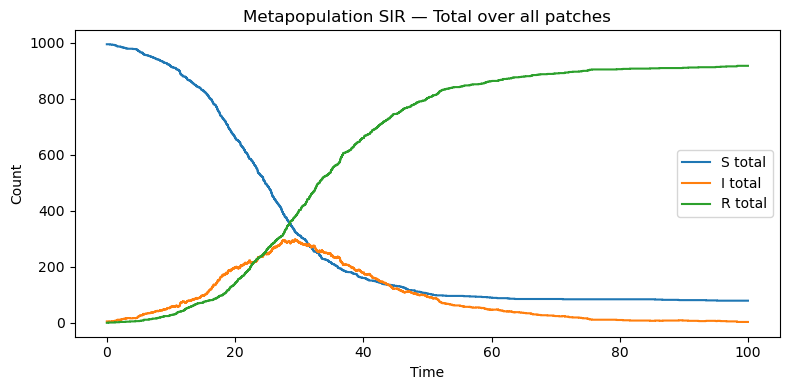

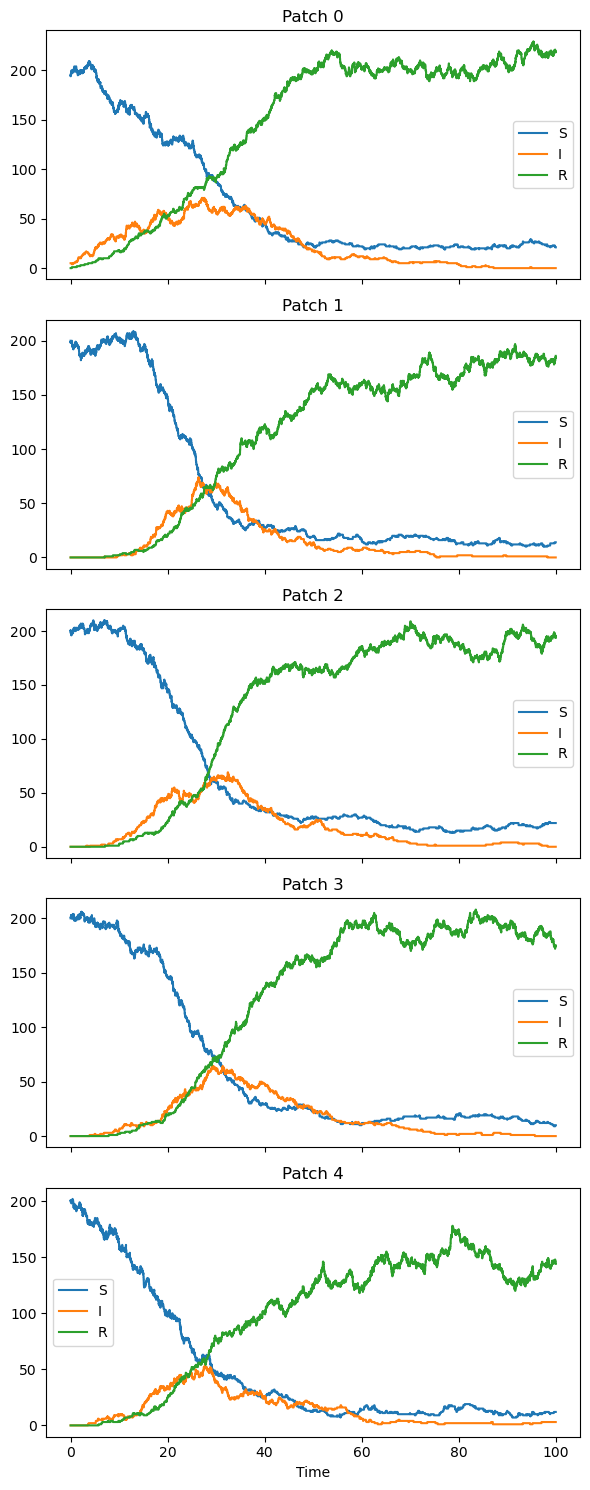

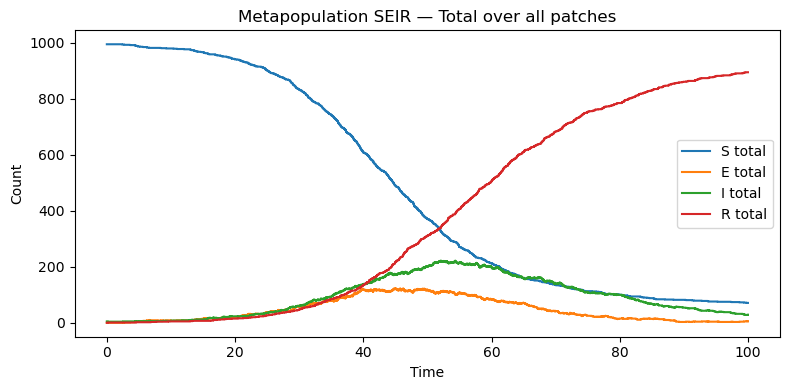

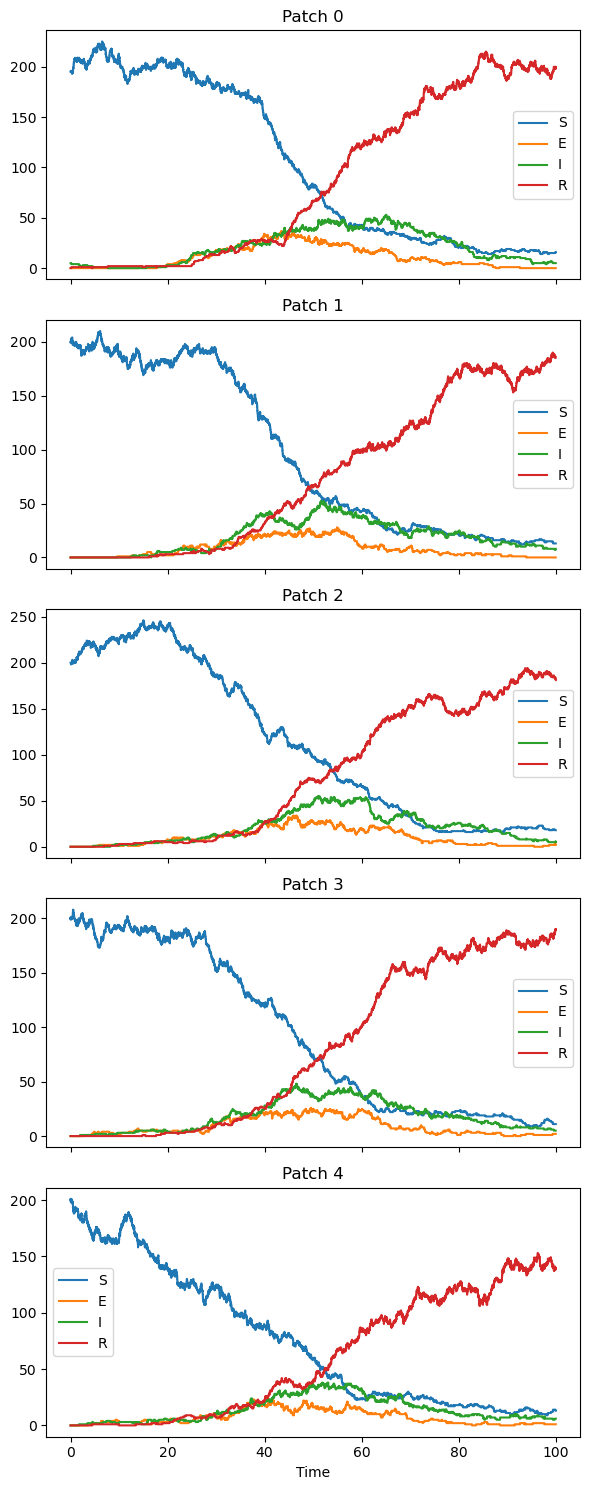

In [11]:
# ---- SETUP ----
P = 5
np.random.seed(123)
# random small movement rates
m_rand = np.random.rand(P,P)*0.05
np.fill_diagonal(m_rand, 0.0)

# initial for SIR: patch0 has 5 infecteds
init_SIR  = np.zeros((P,3),int); init_SIR[:,0]=200
init_SIR[0,1]=5; init_SIR[0,0]-=5

# initial for SEIR: patch0 has 5 infecteds
init_SEIR = np.zeros((P,4),int); init_SEIR[:,0]=200
init_SEIR[0,2]=5; init_SEIR[0,0]-=5

# time horizon
T = 100.0

# ---- SIMULATE & PLOT SIR ----
t_sir, st_sir = simulate_metapop_ctmc(
    model='SIR', beta=0.3, gamma=0.1,
    movement=m_rand,
    init=init_SIR, T=T
)
# totals
tot_S = st_sir[:,:,0].sum(1)
tot_I = st_sir[:,:,1].sum(1)
tot_R = st_sir[:,:,2].sum(1)

plt.figure(figsize=(8,4))
plt.step(t_sir, tot_S, where='post', label='S total')
plt.step(t_sir, tot_I, where='post', label='I total')
plt.step(t_sir, tot_R, where='post', label='R total')
plt.title("Metapopulation SIR — Total over all patches")
plt.xlabel("Time"); plt.ylabel("Count"); plt.legend()
plt.tight_layout()
plt.show()

# per‐patch SIR
fig, axs = plt.subplots(P,1,figsize=(6,3*P),sharex=True)
for i in range(P):
    axs[i].step(t_sir, st_sir[:,i,0],where='post',label='S')
    axs[i].step(t_sir, st_sir[:,i,1],where='post',label='I')
    axs[i].step(t_sir, st_sir[:,i,2],where='post',label='R')
    axs[i].set_title(f'Patch {i}')
    axs[i].legend()
plt.xlabel("Time")
plt.tight_layout()
plt.show()

# ---- SIMULATE & PLOT SEIR ----
t_seir, st_seir = simulate_metapop_ctmc(
    model='SEIR', beta=0.3, sigma=0.2, gamma=0.1,
    movement=m_rand,
    init=init_SEIR, T=T
)
# totals
tot_S = st_seir[:,:,0].sum(1)
tot_E = st_seir[:,:,1].sum(1)
tot_I = st_seir[:,:,2].sum(1)
tot_R = st_seir[:,:,3].sum(1)

plt.figure(figsize=(8,4))
plt.step(t_seir, tot_S, where='post', label='S total')
plt.step(t_seir, tot_E, where='post', label='E total')
plt.step(t_seir, tot_I, where='post', label='I total')
plt.step(t_seir, tot_R, where='post', label='R total')
plt.title("Metapopulation SEIR — Total over all patches")
plt.xlabel("Time"); plt.ylabel("Count"); plt.legend()
plt.tight_layout()
plt.show()

# per‐patch SEIR
fig, axs = plt.subplots(P,1,figsize=(6,3*P),sharex=True)
for i in range(P):
    axs[i].step(t_seir, st_seir[:,i,0],where='post',label='S')
    axs[i].step(t_seir, st_seir[:,i,1],where='post',label='E')
    axs[i].step(t_seir, st_seir[:,i,2],where='post',label='I')
    axs[i].step(t_seir, st_seir[:,i,3],where='post',label='R')
    axs[i].set_title(f'Patch {i}')
    axs[i].legend()
plt.xlabel("Time")
plt.tight_layout()
plt.show()

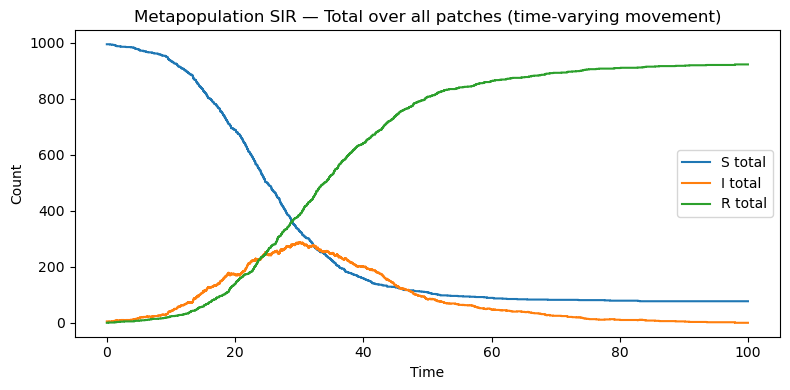

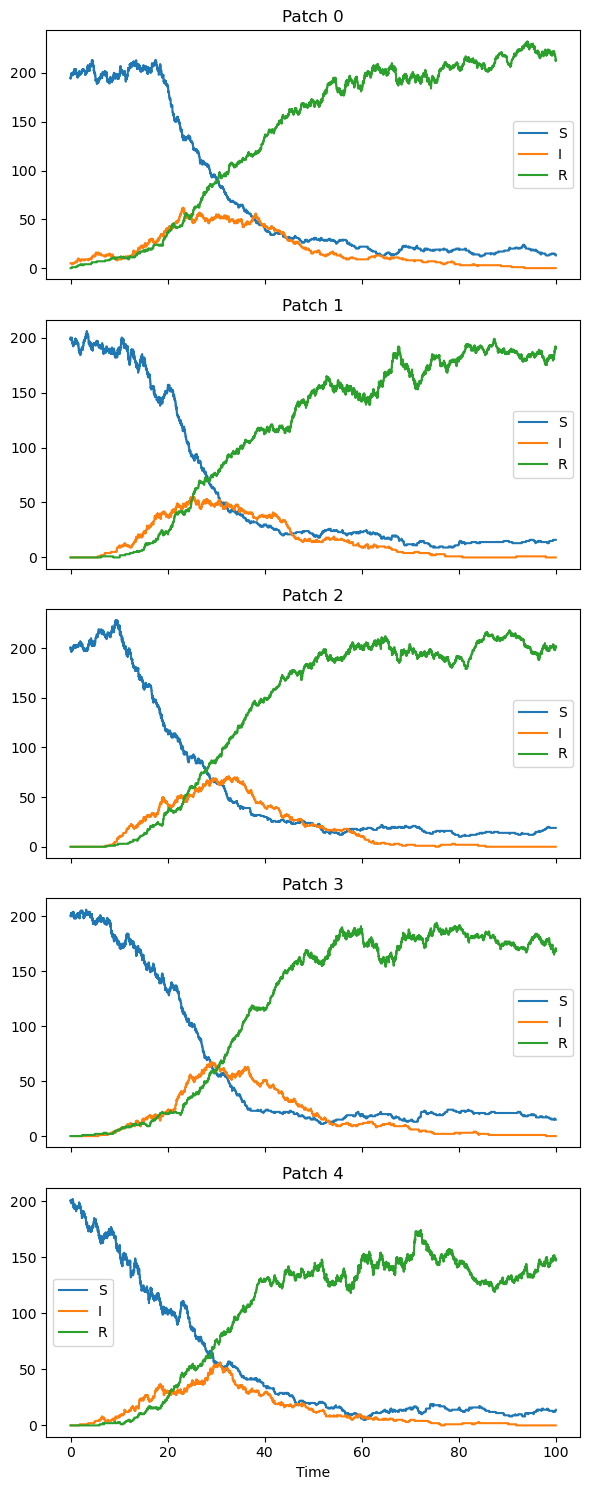

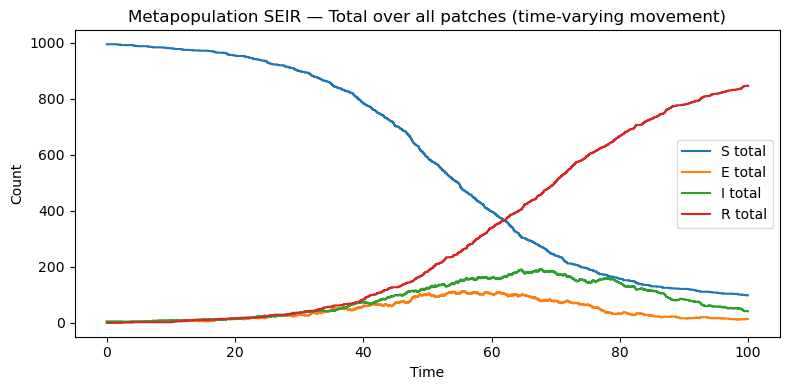

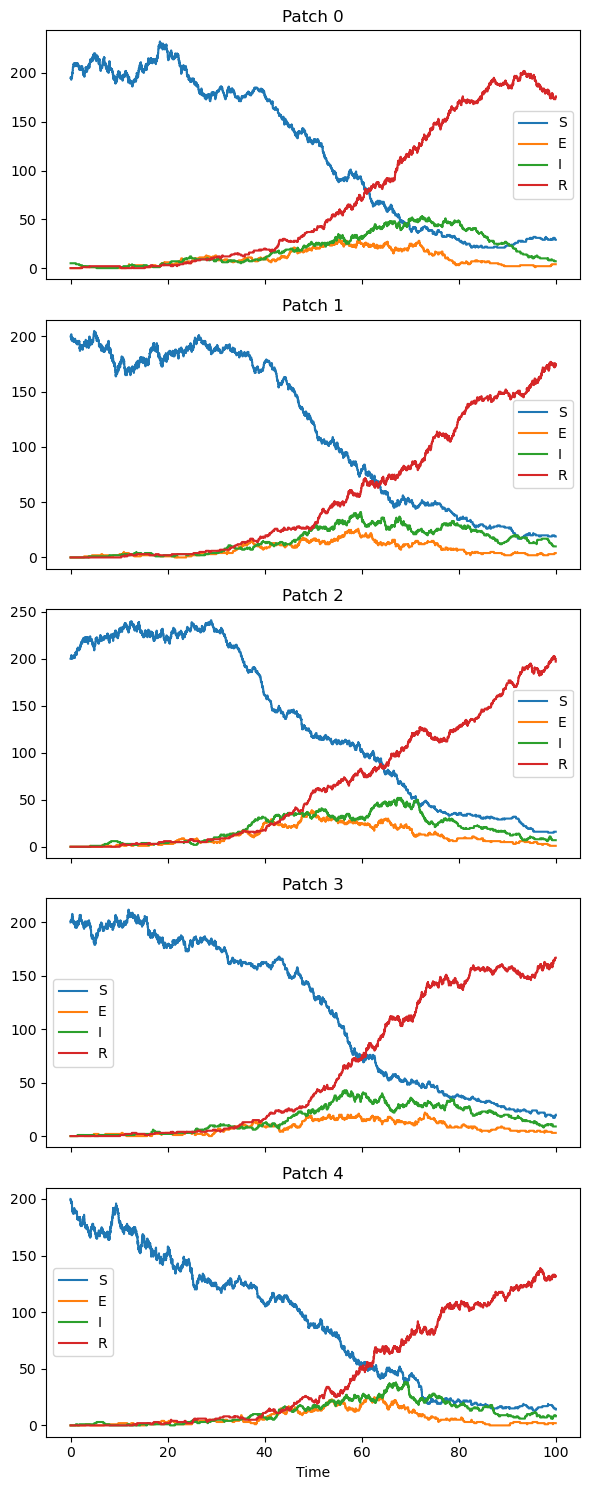

In [12]:
# ---- SETUP ----
P = 5
np.random.seed(123)
# a “base” random movement matrix (just for the shape)
m_base = np.random.rand(P, P) * 0.05
np.fill_diagonal(m_base, 0.0)

# time‐varying movement function: sinusoidal modulation of m_base
def m_time(t):
    """
    Returns movement‐rate matrix at time t,
    oscillating between 0.5× and 1.5× the base rates.
    """
    factor = 1.0 + 0.5 * np.sin(2 * np.pi * t / 50.0)
    return factor * m_base

# initial for SIR: patch0 has 5 infecteds
init_SIR  = np.zeros((P,3),int)
init_SIR[:,0] = 200
init_SIR[0,1] = 5
init_SIR[0,0] -= 5

# initial for SEIR: patch0 has 5 infecteds
init_SEIR = np.zeros((P,4),int)
init_SEIR[:,0] = 200
init_SEIR[0,2] = 5
init_SEIR[0,0] -= 5

# time horizon
T = 100.0

# ---- SIMULATE & PLOT SIR ----
t_sir, st_sir = simulate_metapop_ctmc(
    model='SIR',
    beta=0.3,
    gamma=0.1,
    movement=m_time,    # <— time‐varying
    init=init_SIR,
    T=T
)

# totals
tot_S = st_sir[:,:,0].sum(1)
tot_I = st_sir[:,:,1].sum(1)
tot_R = st_sir[:,:,2].sum(1)

plt.figure(figsize=(8,4))
plt.step(t_sir, tot_S, where='post', label='S total')
plt.step(t_sir, tot_I, where='post', label='I total')
plt.step(t_sir, tot_R, where='post', label='R total')
plt.title("Metapopulation SIR — Total over all patches (time‐varying movement)")
plt.xlabel("Time"); plt.ylabel("Count"); plt.legend()
plt.tight_layout()
plt.show()

# per‐patch SIR
fig, axs = plt.subplots(P,1,figsize=(6,3*P),sharex=True)
for i in range(P):
    axs[i].step(t_sir, st_sir[:,i,0], where='post', label='S')
    axs[i].step(t_sir, st_sir[:,i,1], where='post', label='I')
    axs[i].step(t_sir, st_sir[:,i,2], where='post', label='R')
    axs[i].set_title(f'Patch {i}')
    axs[i].legend()
plt.xlabel("Time")
plt.tight_layout()
plt.show()

# ---- SIMULATE & PLOT SEIR ----
t_seir, st_seir = simulate_metapop_ctmc(
    model='SEIR',
    beta=0.3,
    sigma=0.2,
    gamma=0.1,
    movement=m_time,    # <— time‐varying
    init=init_SEIR,
    T=T
)

# totals
tot_S = st_seir[:,:,0].sum(1)
tot_E = st_seir[:,:,1].sum(1)
tot_I = st_seir[:,:,2].sum(1)
tot_R = st_seir[:,:,3].sum(1)

plt.figure(figsize=(8,4))
plt.step(t_seir, tot_S, where='post', label='S total')
plt.step(t_seir, tot_E, where='post', label='E total')
plt.step(t_seir, tot_I, where='post', label='I total')
plt.step(t_seir, tot_R, where='post', label='R total')
plt.title("Metapopulation SEIR — Total over all patches (time‐varying movement)")
plt.xlabel("Time"); plt.ylabel("Count"); plt.legend()
plt.tight_layout()
plt.show()

# per‐patch SEIR
fig, axs = plt.subplots(P,1,figsize=(6,3*P),sharex=True)
for i in range(P):
    axs[i].step(t_seir, st_seir[:,i,0], where='post', label='S')
    axs[i].step(t_seir, st_seir[:,i,1], where='post', label='E')
    axs[i].step(t_seir, st_seir[:,i,2], where='post', label='I')
    axs[i].step(t_seir, st_seir[:,i,3], where='post', label='R')
    axs[i].set_title(f'Patch {i}')
    axs[i].legend()
plt.xlabel("Time")
plt.tight_layout()
plt.show()

<>:85: SyntaxWarning: invalid escape sequence '\ '
<>:85: SyntaxWarning: invalid escape sequence '\ '
C:\Users\10191\AppData\Local\Temp\ipykernel_31048\3826279898.py:85: SyntaxWarning: invalid escape sequence '\ '
  plt.plot(t_star, I_pred, 'r-', label='PINN-predicted\n cum.\ infections')


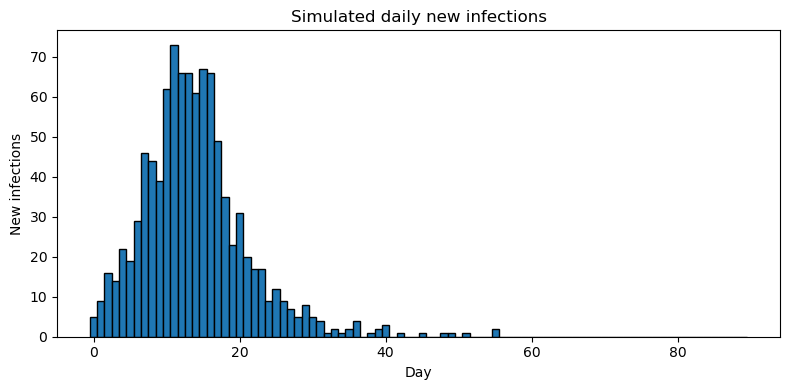

AttributeError: module 'tensorflow' has no attribute 'truncated_normal'

In [22]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from PINN.PINN_model import PhysicsInformedNN

# 3) simulate for T days
T = 160
times, states = simulate_epid_ctmc(model='SIR',
                                   beta=0.4, gamma=0.1,
                                   S0=990, I0=10, R0=0,
                                   T=T)

# 4) extract infection events by looking at ΔI = +1
event_times = []
for i in range(1, len(states)):
    Δ = states[i,1] - states[i-1,1]
    if Δ == 1:
        event_times.append(times[i])

# 5) bin into integer days [0,1),[1,2),…
days = np.arange(0, int(np.ceil(times[-1]))+1)
I_new = np.array([sum((day <= t < day+1) for t in event_times) for day in days])

# plot to check
plt.figure(figsize=(8,4))
plt.bar(days, I_new, width=1, edgecolor='k')
plt.xlabel("Day")
plt.ylabel("New infections")
plt.title("Simulated daily new infections")
plt.tight_layout()
plt.show()

# 6) build the arrays PINN expects
I_new = I_new.reshape(-1,1)            # T×1
D_new = np.zeros_like(I_new)           # no deaths in SIR
H     = np.zeros_like(I_new)           # no hospitalization data
I_sum = np.cumsum(I_new).reshape(-1,1)
D_sum = np.cumsum(D_new).reshape(-1,1)
t_star = np.arange(len(I_new)).reshape(-1,1)

# scaling factor (optional; follow your original script)
sf = 1e-4
N_pop = 9992430 * sf
I_new  = I_new  * sf
D_new  = D_new  * sf
H      = H      * sf
I_sum  = I_sum  * sf
D_sum  = D_sum  * sf

# initial conditions for PINN
I0_new  = I_new[0:1,:]
D0_new  = D_new[0:1,:]
H0      = H    [0:1,:]
I0_sum  = I_sum[0:1,:]
D0_sum  = D_sum[0:1,:]
J0      = np.array([[0.0]])
R0      = np.array([[0.0]])
U0      = [I0_new, D0_new, H0, I0_sum, D0_sum, J0, R0]

# 7) PINN architecture & residual points
layers       = [1] + 10*[32] + [8]
layers_beta  = [1] + 1*[5]  + [1]
layers_p     = [1] + 1*[5]  + [1]
layers_q     = [1] + 10*[32] + [1]
N_f = 1000
t_f = np.linspace(t_star.min(), t_star.max(), N_f).reshape(-1,1)

# 8) train the model
model = PhysicsInformedNN(t_star, I_new, D_new, H,
                          I_sum, D_sum,
                          U0, t_f,
                          t_star.min(0), t_star.max(0),
                          N_pop,
                          layers, layers_beta, layers_p, layers_q,
                          sf)

# 9) run optimization
model.train(10000)   # e.g. 10k iterations of L-BFGS/BFGS

# 10) (optional) plot your PINN’s fit back against the simulated data
t_pred, I_pred, _, _, _, _, _ = model.predict(t_star)
plt.figure(figsize=(8,4))
plt.plot(t_star, I_sum, 'k.', label='True cum.\n infections')
plt.plot(t_star, I_pred, 'r-', label='PINN-predicted\n cum.\ infections')
plt.xlabel("Day")
plt.legend()
plt.tight_layout()
plt.show()
